In [1]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
from transformers import AutoTokenizer
from torch.utils.data import DataLoader, WeightedRandomSampler
import pprint as pp
from utils.param_objects import EmpatheticDialogueParams, MELDParams
from models.emotimebert import EmotionalTimeBert, DatasetMode
from sklearn.metrics import f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt
from data_handling.datasets.empathetic_dialogues import EmpatheticDialoguesDataset
from data_handling.datasets.meld import MELDDataset
from data_handling.data_cleaning.empathetic_dialogues import load_empath_conversations, load_empath_test_conversations
from data_handling.data_cleaning.meld import load_meld_dfs, load_meld_split, load_meld_conversations, load_meld_test_conversations, emotion_id_to_label, label_to_emotion_id
from utils.utils import train_model, validate_model, test_model, collate_conversations, create_new_run_dir, save_table_as_csv, compute_class_weights, FocalLoss

from pathlib import Path
import re
os.environ["TOKENIZERS_PARALLELISM"] = "false"
TRAINING = True


/home/cayden/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_save_location = create_new_run_dir(new_dir=TRAINING)

In [3]:
conversations, val_conversations, emotion_labels, emotion_to_id = load_empath_conversations()
meld_data, val_data = load_meld_dfs()
meld_conversations, val_meld_conversations, meld_emotions, meld_labels = load_meld_conversations()

In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
dataset = MELDDataset(meld_conversations, tokenizer)
val_dataset = MELDDataset(val_meld_conversations, tokenizer)


In [5]:
# loader = DataLoader(
#     dataset,
#     batch_size=16,
#     shuffle=True,
#     num_workers=8,
#     # pin_memory=True,
#     # persistent_workers=True,
#     collate_fn=lambda x: collate_conversations(x, tokenizer),
# )
#
val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False, # future me, keep it false, helps reproduce results
    num_workers=8,
    #pin_memory=True,
    # persistent_workers=True,
    collate_fn=lambda x: collate_conversations(x, tokenizer),
)

RARE_EMOTIONS = {
    label_to_emotion_id["fear"],
    label_to_emotion_id["joy"],
    label_to_emotion_id["disgust"],
}

def conversation_weight(item, rare_emotions, boost=10.0):
    labels = item["labels"]
    if any(lbl.item() in rare_emotions for lbl in labels if lbl.item() != -1):
        return boost
    return 1.0

train_weights = [
    conversation_weight(item, RARE_EMOTIONS)
    for item in dataset
]

train_sampler = WeightedRandomSampler(
    weights=train_weights,
    num_samples=len(dataset),
    replacement=True
)

loader = DataLoader(
    dataset,
    batch_size=16,
    # shuffle=True,
    num_workers=8,
    sampler=train_sampler,
    collate_fn=lambda x: collate_conversations(x, tokenizer)
)

# val_weights = [
#     conversation_weight(item, RARE_EMOTIONS)
#     for item in val_dataset
# ]
#
# val_sampler = WeightedRandomSampler(
#     weights=val_weights,
#     num_samples=len(val_dataset),
#     replacement=True
# )
#
# val_loader = DataLoader(
#     val_dataset,
#     batch_size=16,
#     # shuffle=False, # future me, keep it false, helps reproduce results
#     num_workers=8,
#     sampler=val_sampler,
#     #pin_memory=True,
#     # persistent_workers=True,
#     collate_fn=lambda x: collate_conversations(x, tokenizer),
# )

In [6]:
device = "cpu"

if torch.cuda.is_available():
    device = "cuda"
    print("Device:", torch.cuda.get_device_name(0))
    print("CUDA Enabled!")

meld_params = MELDParams(num_labels=len(meld_emotions))

model = EmotionalTimeBert("./medbert_4_epochs", meld_params=meld_params).to(device)

if not TRAINING:
    # model.load_state_dict(torch.load(f"{base_save_location}/model.pt")) #  emotional_time_bert_GRU_To_Show5.pt"
    checkpoint = torch.load(f"{base_save_location}/model.pt")
    model.load_state_dict(checkpoint["model_state"])
    model.use_gru = checkpoint["use_gru"]

weights = compute_class_weights(loader, len(meld_emotions), device)

# criterion = torch.nn.CrossEntropyLoss(
#     weight=weights,
#     ignore_index=-1
# )

criterion = FocalLoss(
    alpha=weights,
    gamma=2.0,
    ignore_index=-1
)

adam_params = [
    {"params": model.encoder.encoder.layer[-6:].parameters(), "lr": 1e-5},
    {"params": model.temporal_transformer.parameters(), "lr": 3e-4},

    {"params": model.speakers_embed.parameters(), "lr": 3e-4},
]

if model.dataset_mode == DatasetMode.BOTH:
    adam_params.append({"params": model.head_empath.parameters(), "lr": 3e-4})
    adam_params.append({"params": model.head_meld.parameters(), "lr": 3e-4})
    adam_params.append({"params": model.time_embed.parameters(), "lr": 3e-4})
elif model.dataset_mode == DatasetMode.MELD:
    adam_params.append({"params": model.head_meld.parameters(), "lr": 1e-4})
    adam_params.append({"params": model.time_proj.parameters(), "lr": 1e-4})
else:
    adam_params.append({"params": model.head_empath.parameters(), "lr": 3e-4})
    adam_params.append({"params": model.time_embed.parameters(), "lr": 3e-4})

optimizer = torch.optim.AdamW(adam_params)

Device: NVIDIA GeForce RTX 5080
CUDA Enabled!


In [7]:
train_step_losses = []
val_step_losses = []
global_steps = []
val_steps = []
val_macro_f1 = []
val_macro_f1_steps = []
best_f1 = 0

if TRAINING:
    num_of_epochs = 15
    step = 0
    for epoch in range(num_of_epochs):
        progress_bar = tqdm(loader, total=len(loader))
        avg_loss, step = train_model(model, optimizer, device, criterion=criterion, bar=progress_bar, train_step_losses=train_step_losses, global_steps=global_steps, start_step=step)
        validate_progress = tqdm(val_loader, total=len(val_loader))
        val_loss, val_f1, step, report = validate_model(model, device, criterion=criterion, bar=validate_progress, val_step_losses=val_step_losses, val_steps=val_steps, start_step=step)

        dead_classes = [
            cls for cls, stats in report.items()
            if isinstance(stats, dict)
            and "recall" in stats
            and stats["recall"] < 0.02
        ]

        alive_ratio = 1 - len(dead_classes) / len(meld_emotions)
        if alive_ratio >= 0.80 and not model.use_gru:
            model.use_gru = True
            print("Enough classes are alive, enabled GRU")
        elif alive_ratio < 0.80:
            print("Not enough classes are alive yet", emotion_id_to_label[np.array(dead_classes).astype(int)])

        val_macro_f1.append(val_f1)
        val_macro_f1_steps.append(step)

        print(f"Epoch {epoch+1}: train loss = {avg_loss:.4f}")
        print(f"Epoch {epoch+1}: val loss   = {val_loss:.4f}")
        print(f"Epoch {epoch+1}: val F1     = {val_f1:.4f}")

        # if val_f1 > best_f1:
        #     best_f1 = val_f1
        # else:
        #     break

    torch.save({
        "model_state": model.state_dict(),
        "use_gru": model.use_gru,
        "alpha": model.alpha if hasattr(model, "alpha") else None,
    }, f"{base_save_location}/model.pt")
    save_table_as_csv(global_steps, f"{base_save_location}/global_steps.csv")
    save_table_as_csv(train_step_losses, f"{base_save_location}/train_step_losses.csv")
    save_table_as_csv(val_step_losses, f"{base_save_location}/val_step_losses.csv")
    save_table_as_csv(val_steps, f"{base_save_location}/val_steps.csv")
    save_table_as_csv(val_macro_f1, f"{base_save_location}/val_macro_f1.csv")
    save_table_as_csv(val_macro_f1_steps, f"{base_save_location}/val_macro_f1_steps.csv")



Epoch 15: train loss = 0.1928
Epoch 15: val loss   = 1.0278
Epoch 15: val F1     = 0.4147


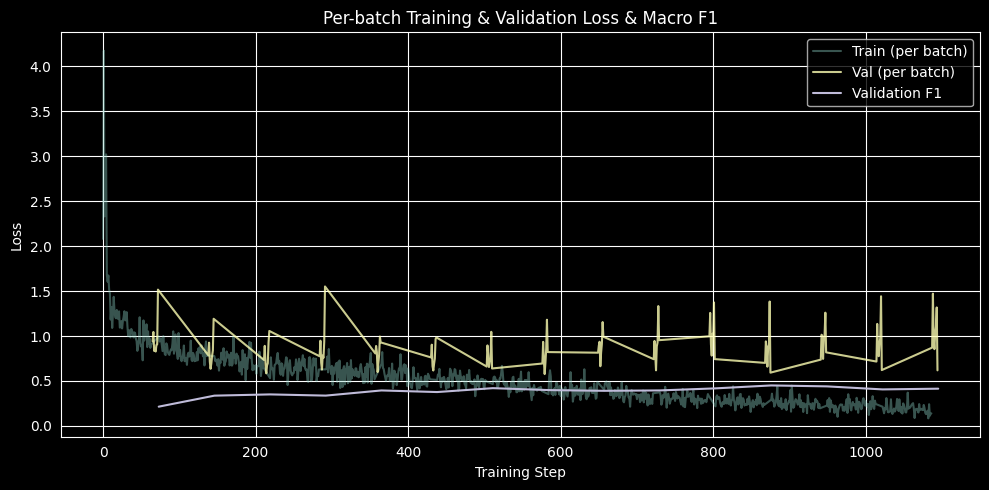

In [8]:
if TRAINING:
    plt.figure(figsize=(10, 5))
    plt.plot(global_steps, train_step_losses, alpha=0.4, label="Train (per batch)")
    plt.plot(val_steps, val_step_losses, alpha=0.8, label="Val (per batch)")
    plt.plot(val_macro_f1_steps, val_macro_f1, alpha=1, label="Validation F1")

    plt.xlabel("Training Step")
    plt.ylabel("Loss")
    plt.title("Per-batch Training & Validation Loss & Macro F1")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{base_save_location}/Unsmoothed.png")


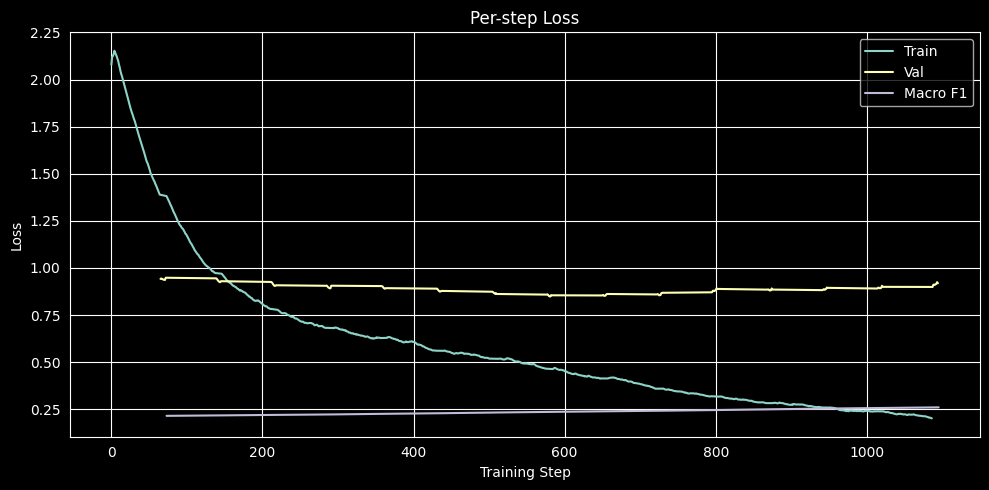

In [9]:
def ema(values, beta=0.98):
    smoothed = []
    avg = values[0]
    for v in values:
        avg = beta * avg + (1 - beta) * v
        smoothed.append(avg)
    return smoothed

if TRAINING:
    plt.figure(figsize=(10, 5))
    plt.plot(global_steps, ema(train_step_losses), label="Train")
    plt.plot(val_steps, ema(val_step_losses), label="Val")
    plt.plot(val_macro_f1_steps, ema(val_macro_f1), alpha=1, label="Macro F1")
    plt.xlabel("Training Step")
    plt.ylabel("Loss")
    plt.title("Per-step Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{base_save_location}/Smoothed.png")

In [10]:
test_conversations = load_meld_test_conversations(emotion_to_id)

In [11]:
test_dataset = MELDDataset(test_conversations, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=8,
    collate_fn=lambda x: collate_conversations(x, tokenizer)
)

In [12]:
test_f1 = test_model(
    model=model,
    dataloader=test_loader,
    device=device,
    emotion_labels=meld_labels,
    save_results=True,
    save_dir=f"{base_save_location}/classification_report.csv",
)
# also look into bert's special keywords

In [13]:
def ablation(model, dataloader, device, ablate):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            utterance_mask = batch["utterance_mask"].to(device)

            timestamps = batch["timestamps"].to(device)
            speakers = batch["speakers"].to(device)

            if ablate == "time_zero":
                timestamps = torch.zeros_like(timestamps)
            elif ablate == "time_shuffle":
                timestamps = timestamps[torch.randperm(timestamps.size(0))]
            elif ablate == "speaker_zero":
                speakers = torch.zeros_like(speakers)

            logits = model(
                input_ids, attention_mask,
                timestamps, speakers,
                labels, utterance_mask
            )

            preds = logits.argmax(-1)
            mask = labels != -1

            all_preds.append(preds[mask].cpu())
            all_labels.append(labels[mask].cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    return f1_score(all_labels, all_preds, average="macro")

In [14]:
normal = ablation(model, val_loader, device, "none")
print("Normal:", normal)

Normal: 0.4146880272220549


In [15]:
time_zero = ablation(model, val_loader, device, "time_zero")
print(f"Time zero: {time_zero} Difference: {time_zero - normal}")

Time zero: 0.3935277205745509 Difference: -0.021160306647504012


In [16]:
time_shuffle = ablation(model, val_loader, device, "time_shuffle")
print(f"Time shuffle: {time_shuffle} Difference: {time_shuffle - normal}")

Time shuffle: 0.419922826027329 Difference: 0.00523479880527411


In [17]:
speaker_zero = ablation(model, val_loader, device, "speaker_zero")
print(f"Speaker zero: {speaker_zero} Difference: {speaker_zero - normal}")

Speaker zero: 0.417215256949405 Difference: 0.0025272297273500888
